<a href="https://colab.research.google.com/github/ensarakbas77/Match-Result-Prediction/blob/main/TimesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snb
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
import time
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [ ]:
file_path= 'Matches.xlsx'
df=pd.read_excel(file_path)

# Sadece geçerli sonuçları tut
df = df[df['Sonuç'].isin([-1, 0, 1])]

# Haritalama işlemi
sonuc_mapping = {-1: 0, 0: 1, 1: 2}
df['Sonuç'] = df['Sonuç'].map(sonuc_mapping)

# **SEKANS VE STATİK ÖZELLİKLER**

In [ ]:
# Takıma ve tarihe göre sırala
df = df.sort_values(by=['Takım ID', 'Tarih'])

# Boş değeri doldur
df["Şut Verimliliği"] = df["Şut Verimliliği"].fillna(df["Şut Verimliliği"].mean())

# Feature listeleri
sequence_features = [
    'Gol', 'Rakip Gol', 'Topla Oynama(%)', 'Şut', 'İsabetli Şut', 'Başarılı Pas',
    'Pas Başarısı(%)', 'Korner', 'Orta', 'Faul', 'Ofsayt',
    'Rakip Topla Oynama(%)', 'Rakip Şut', 'Rakip İsabetli Şut', 'Rakip Başarılı Pas',
    'Rakip Pas Başarısı(%)', 'Rakip Korner', 'Rakip Orta', 'Rakip Faul', 'Rakip Ofsayt'
]

static_features = [
    'Takım ID', 'Rakip Takım ID', 'Is_Home', 'Sezon', 'Ay', 'Haftanın Günü',
    'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı'
]


feature_means = df[sequence_features].mean().values

def pad_sequence(seq, K, mean_vec):
    if len(seq) < K:
        padding = np.tile(mean_vec, (K - len(seq), 1))
        return np.vstack([padding, seq])
    return seq


K = 10
X_seq = []
X_static = []
y = []

for idx, row in df.iterrows():
    takim_id = row['Takım ID']
    rakip_id = row['Rakip Takım ID']
    tarih = row['Tarih']

    takim_gecmis = df[(df['Takım ID'] == takim_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    rakip_gecmis = df[(df['Takım ID'] == rakip_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    #if len(takim_gecmis) < 1 or len(rakip_gecmis) < 1:
        #continue

    takim_seq = pad_sequence(takim_gecmis[sequence_features].values, K, feature_means)
    rakip_seq = pad_sequence(rakip_gecmis[sequence_features].values, K, feature_means)

    full_seq = np.vstack([takim_seq, rakip_seq])

    static_vec = row[static_features].values.astype(np.float32)
    label = row['Sonuç']

    X_seq.append(full_seq)
    X_static.append(static_vec)
    y.append(label)


In [ ]:
X_seq = np.array(X_seq, dtype=np.float32)
X_static = np.array(X_static, dtype=np.float32)
y = np.array(y, dtype=np.int64)

print("X_seq shape     :", X_seq.shape)
print("X_static shape  :", X_static.shape)
print("y shape         :", y.shape)
print("Sınıf dağılımı  :", Counter(y))

X_seq shape     : (3734, 20, 20)
X_static shape  : (3734, 9)
y shape         : (3734,)
Sınıf dağılımı  : Counter({np.int64(2): 2241, np.int64(0): 788, np.int64(1): 705})


# **Küme Ayrımı**

In [ ]:
val_ratio = 0.15
test_ratio = 0.15

total_samples = len(X_seq)
test_size = int(total_samples * test_ratio)
val_size = int(total_samples * val_ratio)
train_size = total_samples - val_size - test_size

X_seq_train = X_seq[:train_size]
X_static_train = X_static[:train_size]
y_train = y[:train_size]

X_seq_val = X_seq[train_size:train_size + val_size]
X_static_val = X_static[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_seq_test = X_seq[-test_size:]
X_static_test = X_static[-test_size:]
y_test = y[-test_size:]


print("Train:", len(y_train), "Val:", len(y_val), "Test:", len(y_test))
print("Train Sınıf Dağılımı:", Counter(y_train))
print("Val   Sınıf Dağılımı:", Counter(y_val))
print("Test  Sınıf Dağılımı:", Counter(y_test))

Train: 2614 Val: 560 Test: 560
Train Sınıf Dağılımı: Counter({np.int64(2): 1604, np.int64(0): 512, np.int64(1): 498})
Val   Sınıf Dağılımı: Counter({np.int64(2): 338, np.int64(0): 121, np.int64(1): 101})
Test  Sınıf Dağılımı: Counter({np.int64(2): 299, np.int64(0): 155, np.int64(1): 106})


# **Encoding + Ölçekleme**

In [ ]:
# 1. Tüm setleri DataFrame'e çevir
df_static_train = pd.DataFrame(X_static_train, columns=static_features)
df_static_val   = pd.DataFrame(X_static_val,   columns=static_features)
df_static_test  = pd.DataFrame(X_static_test,  columns=static_features)

# 2. Takım ve Rakip ID'leri ayır
takim_ids_train = df_static_train["Takım ID"].values.astype(np.int64)
rakip_ids_train = df_static_train["Rakip Takım ID"].values.astype(np.int64)

takim_ids_val = df_static_val["Takım ID"].values.astype(np.int64)
rakip_ids_val = df_static_val["Rakip Takım ID"].values.astype(np.int64)

takim_ids_test = df_static_test["Takım ID"].values.astype(np.int64)
rakip_ids_test = df_static_test["Rakip Takım ID"].values.astype(np.int64)

# 3. Encoding yapılacak sütunlar
categorical_ohe_cols = ['Sezon', 'Ay', 'Haftanın Günü']
numerical_cols = ['Is_Home', 'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı']

# 4. One-Hot Encoder (sadece train'e fit et)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(df_static_train[categorical_ohe_cols])

# 5. Encode edilmiş kategorik özellikler
ohe_train = ohe.transform(df_static_train[categorical_ohe_cols])
ohe_val   = ohe.transform(df_static_val[categorical_ohe_cols])
ohe_test  = ohe.transform(df_static_test[categorical_ohe_cols])

# 6. Numerik özellikler için StandardScaler (sadece train'e fit et)
scaler = StandardScaler()
scaler.fit(df_static_train[numerical_cols])

scaled_train = scaler.transform(df_static_train[numerical_cols])
scaled_val   = scaler.transform(df_static_val[numerical_cols])
scaled_test  = scaler.transform(df_static_test[numerical_cols])

# 7. Final encode edilmiş X_static verileri
X_static_train_encoded = np.hstack([ohe_train, scaled_train]).astype(np.float32)
X_static_val_encoded   = np.hstack([ohe_val, scaled_val]).astype(np.float32)
X_static_test_encoded  = np.hstack([ohe_test, scaled_test]).astype(np.float32)


# === SEKANS ÖZELLİKLERİ ===
# X_seq: (N, T=20, F=20)
N_train = X_seq_train.shape[0]
N_val   = X_seq_val.shape[0]
N_test  = X_seq_test.shape[0]
seq_len = X_seq_train.shape[1]
F       = X_seq_train.shape[2]

scaler_seq = StandardScaler()

# --- Train: fit + transform ---
X_seq_train_flat = X_seq_train.reshape(-1, F)  # (N*T, F)
X_seq_train_scaled_flat = scaler_seq.fit_transform(X_seq_train_flat)
X_seq_train_scaled = X_seq_train_scaled_flat.reshape(N_train, seq_len, F)

# --- Val: transform only ---
X_seq_val_flat = X_seq_val.reshape(-1, F)
X_seq_val_scaled_flat = scaler_seq.transform(X_seq_val_flat)
X_seq_val_scaled = X_seq_val_scaled_flat.reshape(N_val, seq_len, F)

# --- Test: transform only ---
X_seq_test_flat = X_seq_test.reshape(-1, F)
X_seq_test_scaled_flat = scaler_seq.transform(X_seq_test_flat)
X_seq_test_scaled = X_seq_test_scaled_flat.reshape(N_test, seq_len, F)


X_static_train = X_static_train_encoded
X_static_val   = X_static_val_encoded
X_static_test  = X_static_test_encoded

X_seq_train = X_seq_train_scaled
X_seq_val   = X_seq_val_scaled
X_seq_test  = X_seq_test_scaled

# 8. Kontrol
print("X_static_train:", X_static_train.shape)
print("X_static_val  :", X_static_val.shape)
print("X_static_test :", X_static_test.shape)
print()
print("takim_ids_train:", takim_ids_train.shape)
print("takim_ids_test", takim_ids_test.shape)
print("takim_ids_val", takim_ids_val.shape)
print()
print("rakip_ids_train:", rakip_ids_train.shape)
print("rakip_ids_test", rakip_ids_test.shape)
print("rakip_ids_val", rakip_ids_val.shape)
print()
print("X_seq_train:", X_seq_train.shape)
print("X_seq_val  :", X_seq_val.shape)
print("X_seq_test :", X_seq_test.shape)


X_static_train: (2614, 36)
X_static_val  : (560, 36)
X_static_test : (560, 36)

takim_ids_train: (2614,)
takim_ids_test (560,)
takim_ids_val (560,)

rakip_ids_train: (2614,)
rakip_ids_test (560,)
rakip_ids_val (560,)

X_seq_train: (2614, 20, 20)
X_seq_val  : (560, 20, 20)
X_seq_test : (560, 20, 20)


In [ ]:
le = LabelEncoder()

# Tüm ID'leri birleştir
all_ids = np.concatenate([takim_ids_train, takim_ids_val, takim_ids_test,
                          rakip_ids_train, rakip_ids_val, rakip_ids_test])

# Fit işlemi tüm ID'lere yapılmalı
le.fit(all_ids)

# Encode işlemi (dönüştürme)
takim_ids_train_enc = le.transform(takim_ids_train)
rakip_ids_train_enc = le.transform(rakip_ids_train)

takim_ids_val_enc = le.transform(takim_ids_val)
rakip_ids_val_enc = le.transform(rakip_ids_val)

takim_ids_test_enc = le.transform(takim_ids_test)
rakip_ids_test_enc = le.transform(rakip_ids_test)

# Yeni vocab size
team_vocab_size = len(le.classes_)


# **MODEL**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tensöre çevirme
def to_tensor(x, dtype=torch.float32):
    return torch.tensor(x, dtype=dtype)

# Eğitim Tensor
x_seq_train_tensor     = to_tensor(X_seq_train)
x_static_train_tensor  = to_tensor(X_static_train)
takim_ids_train_tensor = torch.tensor(takim_ids_train_enc, dtype=torch.long)
rakip_ids_train_tensor = torch.tensor(rakip_ids_train_enc, dtype=torch.long)
y_train_tensor         = torch.tensor(y_train, dtype=torch.long)

# Validation
x_seq_val_tensor     = to_tensor(X_seq_val)
x_static_val_tensor  = to_tensor(X_static_val)
takim_ids_val_tensor = torch.tensor(takim_ids_val_enc, dtype=torch.long)
rakip_ids_val_tensor = torch.tensor(rakip_ids_val_enc, dtype=torch.long)
y_val_tensor         = torch.tensor(y_val, dtype=torch.long)

# Test
x_seq_test_tensor     = to_tensor(X_seq_test)
x_static_test_tensor  = to_tensor(X_static_test)
takim_ids_test_tensor = torch.tensor(takim_ids_test_enc, dtype=torch.long)
rakip_ids_test_tensor = torch.tensor(rakip_ids_test_enc, dtype=torch.long)
y_test_tensor         = torch.tensor(y_test, dtype=torch.long)



# Eğitim veri seti
train_dataset = TensorDataset(
    x_seq_train_tensor,
    x_static_train_tensor,
    takim_ids_train_tensor,
    rakip_ids_train_tensor,
    y_train_tensor
)

# Validation veri seti
val_dataset = TensorDataset(
    x_seq_val_tensor,
    x_static_val_tensor,
    takim_ids_val_tensor,
    rakip_ids_val_tensor,
    y_val_tensor
)

# Test veri seti
test_dataset = TensorDataset(
    x_seq_test_tensor,
    x_static_test_tensor,
    takim_ids_test_tensor,
    rakip_ids_test_tensor,
    y_test_tensor
)

In [ ]:
import torch.nn.functional as F

class TimesNet(nn.Module):
    def __init__(self,
                 input_dim,
                 seq_len,
                 static_dim,
                 team_vocab_size,
                 embedding_dim=8,
                 num_classes=3,
                 num_blocks=3,
                 hidden_dim=64):

        super(TimesNet, self).__init__()

        self.blocks = nn.ModuleList([
            TimesBlock(input_dim, hidden_dim) for _ in range(num_blocks)
        ])

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.static_proj = nn.Sequential(
            nn.Linear(static_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(32, 16)
        )


        self.team_emb = nn.Embedding(team_vocab_size, embedding_dim)
        self.rival_emb = nn.Embedding(team_vocab_size, embedding_dim)

        total_feat_dim = input_dim + 16 + 2 * embedding_dim
        self.fc = nn.Linear(total_feat_dim, num_classes)

    def forward(self, x_seq, x_static, team_ids, rival_ids):

        for block in self.blocks:
            x_seq = block(x_seq)

        x_seq = x_seq.permute(0, 2, 1)
        x_seq = self.global_pool(x_seq).squeeze(-1)

        x_static_out = self.static_proj(x_static)

        team_vec = self.team_emb(team_ids)
        rival_vec = self.rival_emb(rival_ids)

        full_feat = torch.cat([x_seq, x_static_out, team_vec, rival_vec], dim=1)

        out = self.fc(full_feat)
        return out

class TimesBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, dropout=0.6):
        super(TimesBlock, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(hidden_dim, input_dim, kernel_size=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = out.permute(0, 2, 1)
        return out + x.permute(0, 2, 1)


In [ ]:
input_dim = 20
seq_len = 20
static_dim = X_static_train.shape[1]
team_vocab_size = len(le.classes_)
embedding_dim = 8

model = TimesNet(input_dim=input_dim,
                 seq_len=seq_len,
                 static_dim=static_dim,
                 team_vocab_size=team_vocab_size,
                 embedding_dim=embedding_dim,
                 num_classes=3)

model.to(device)


TimesNet(
  (blocks): ModuleList(
    (0-2): 3 x TimesBlock(
      (conv1): Conv1d(20, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.6, inplace=False)
      (conv2): Conv1d(64, 20, kernel_size=(1,), stride=(1,))
    )
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (static_proj): Sequential(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (team_emb): Embedding(294, 8)
  (rival_emb): Embedding(294, 8)
  (fc): Linear(in_features=52, out_features=3, bias=True)
)

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0.5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Focal Loss tanımı
criterion = FocalLoss(alpha=class_weights_tensor, gamma=0.5)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x_seq, x_static, team_ids, rival_ids, y in dataloader:
        x_seq = x_seq.to(device)
        x_static = x_static.to(device)
        team_ids = team_ids.to(device)
        rival_ids = rival_ids.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        outputs = model(x_seq, x_static, team_ids, rival_ids)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_seq, x_static, team_ids, rival_ids, y in dataloader:
            x_seq = x_seq.to(device)
            x_static = x_static.to(device)
            team_ids = team_ids.to(device)
            rival_ids = rival_ids.to(device)
            y = y.to(device)

            outputs = model(x_seq, x_static, team_ids, rival_ids)
            loss = criterion(outputs, y)

            total_loss += loss.item() * y.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [ ]:
num_epochs = 60
best_val_acc = 0
patience = 10
early_stop_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Eğitim süresi ölçümü
total_train_start = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_timesnet_model.pth")
        # print("→ Yeni en iyi model kaydedildi.")
    else:
        early_stop_counter += 1
        # print(f"→ Gelişme yok. Sabır: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print("⏹️ Early stopping tetiklendi!")
            break


total_train_time = time.time() - total_train_start
print(f"\nToplam eğitim süresi: {total_train_time:.2f} saniye")

[Epoch 1] Train Loss: 0.9361 | Acc: 0.2777 || Val Loss: 0.9364 | Acc: 0.2929
[Epoch 2] Train Loss: 0.9248 | Acc: 0.2724 || Val Loss: 0.9336 | Acc: 0.2929
[Epoch 3] Train Loss: 0.9215 | Acc: 0.2510 || Val Loss: 0.9319 | Acc: 0.3036
[Epoch 4] Train Loss: 0.9130 | Acc: 0.2995 || Val Loss: 0.9276 | Acc: 0.2911
[Epoch 5] Train Loss: 0.9077 | Acc: 0.3015 || Val Loss: 0.9233 | Acc: 0.3071
[Epoch 6] Train Loss: 0.9029 | Acc: 0.3175 || Val Loss: 0.9191 | Acc: 0.3339
[Epoch 7] Train Loss: 0.8982 | Acc: 0.3386 || Val Loss: 0.9133 | Acc: 0.3500
[Epoch 8] Train Loss: 0.8969 | Acc: 0.3428 || Val Loss: 0.9083 | Acc: 0.3625
[Epoch 9] Train Loss: 0.8908 | Acc: 0.3527 || Val Loss: 0.9023 | Acc: 0.3893
[Epoch 10] Train Loss: 0.8832 | Acc: 0.3657 || Val Loss: 0.8963 | Acc: 0.3982
[Epoch 11] Train Loss: 0.8774 | Acc: 0.3940 || Val Loss: 0.8888 | Acc: 0.4054
[Epoch 12] Train Loss: 0.8707 | Acc: 0.3990 || Val Loss: 0.8803 | Acc: 0.4161
[Epoch 13] Train Loss: 0.8731 | Acc: 0.3986 || Val Loss: 0.8737 | Acc: 0.

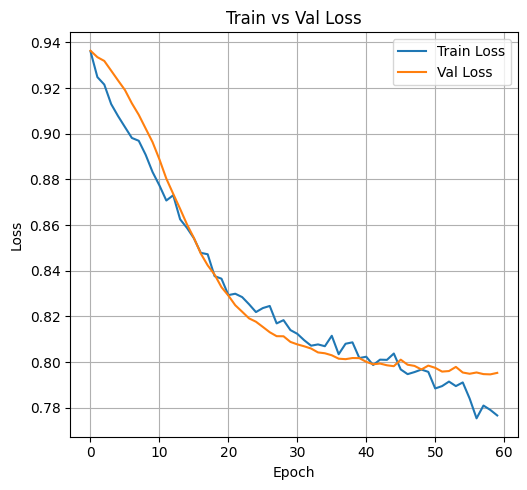

In [ ]:
plt.figure(figsize=(10, 5))

# Kayıp (Loss) Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Test Seti Sonuçları:
Ortalama Test Loss : 1.0113
Test Accuracy       : 0.4946
Toplam Çıkarım Süresi: 0.04 saniye

Test Classification Report:
              precision    recall  f1-score   support

  Mağlubiyet       0.41      0.61      0.49       155
  Beraberlik       0.17      0.19      0.18       106
   Galibiyet       0.77      0.54      0.64       299

    accuracy                           0.49       560
   macro avg       0.45      0.45      0.44       560
weighted avg       0.56      0.49      0.51       560



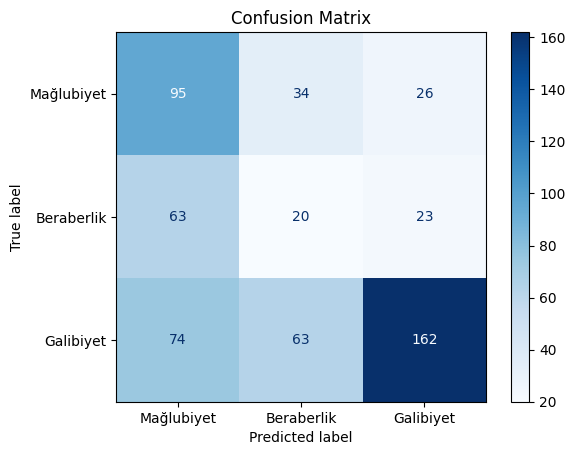

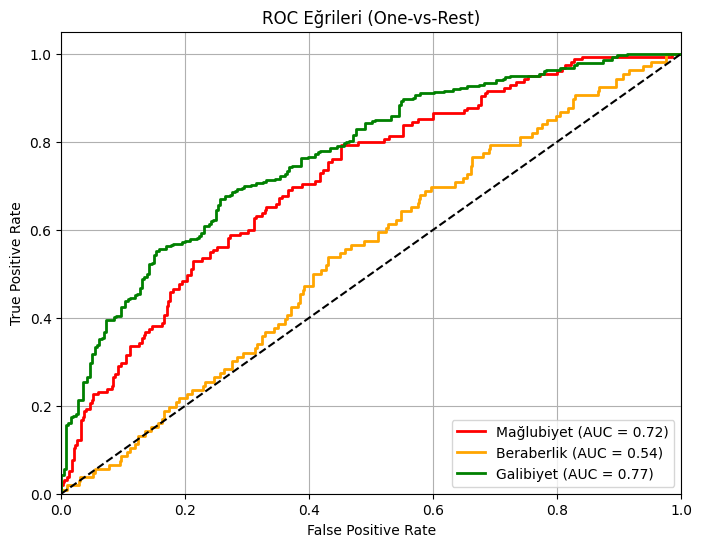

In [ ]:
import torch.nn.functional as F

# En iyi modeli yükle
model.load_state_dict(torch.load("best_timesnet_model.pth"))
model.eval()

all_preds = []
all_targets = []
total_loss = 0.0
total_samples = 0

start_time = time.time()

# Tüm gerekli girdileri modele ver + loss ve doğruluk hesapla
with torch.no_grad():
    for x_seq, x_static, team_ids, rival_ids, y in test_loader:
        x_seq = x_seq.to(device)
        x_static = x_static.to(device)
        team_ids = team_ids.to(device)
        rival_ids = rival_ids.to(device)
        y = y.to(device)

        outputs = model(x_seq, x_static, team_ids, rival_ids)

        loss = F.cross_entropy(outputs, y)
        total_loss += loss.item() * y.size(0)
        total_samples += y.size(0)

        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y.cpu().numpy())

end_time = time.time()
inference_time = end_time - start_time
avg_test_loss = total_loss / total_samples
test_accuracy = accuracy_score(all_targets, all_preds)

print("\nTest Seti Sonuçları:")
print(f"Ortalama Test Loss : {avg_test_loss:.4f}")
print(f"Test Accuracy       : {test_accuracy:.4f}")
print(f"Toplam Çıkarım Süresi: {inference_time:.2f} saniye")

# === Classification Report ===
print("\nTest Classification Report:")
print(classification_report(all_targets, all_preds, target_names=["Mağlubiyet", "Beraberlik", "Galibiyet"]))

# === Confusion Matrix ===
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mağlubiyet", "Beraberlik", "Galibiyet"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# === ROC Eğrileri için: one-hot + probabilistic output ===
y_test_bin = label_binarize(all_targets, classes=[0, 1, 2])
all_probs = []

with torch.no_grad():
    for x_seq, x_static, team_ids, rival_ids, _ in test_loader:
        x_seq = x_seq.to(device)
        x_static = x_static.to(device)
        team_ids = team_ids.to(device)
        rival_ids = rival_ids.to(device)

        logits = model(x_seq, x_static, team_ids, rival_ids)
        probs = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# ROC hesaplaması
fpr, tpr, roc_auc = {}, {}, {}
n_classes = 3
class_names = ['Mağlubiyet', 'Beraberlik', 'Galibiyet']
colors = ['red', 'orange', 'green']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:

# Confusion Matrix al
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2])  # sıralama: Loss, Draw, Win
class_names = ["Mağlubiyet", "Beraberlik", "Galibiyet"]

print("📊 Confusion Matrix:\n", cm)

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

    print(f"\n🔎 Sınıf: {class_name}")
    print(f"✅ Sensitivity (TPR): {sensitivity:.4f}")
    print(f"🚫 Specificity (TNR): {specificity:.4f}")


📊 Confusion Matrix:
 [[ 95  34  26]
 [ 63  20  23]
 [ 74  63 162]]

🔎 Sınıf: Mağlubiyet
✅ Sensitivity (TPR): 0.6129
🚫 Specificity (TNR): 0.6617

🔎 Sınıf: Beraberlik
✅ Sensitivity (TPR): 0.1887
🚫 Specificity (TNR): 0.7863

🔎 Sınıf: Galibiyet
✅ Sensitivity (TPR): 0.5418
🚫 Specificity (TNR): 0.8123
